# Gendist V1.0
## Rotation trenches

In [5]:
import os
from datetime import datetime

date_str = datetime.now().strftime("%y%m%d%H%M")
path_base = f"exp-{date_str}"

path_base = os.path.join("outputs", path_base)
path_output = os.path.join(path_base, "output")
path_logs = os.path.join(path_base, "logs")

print(path_base)

outputs/exp-2203211539


In [4]:
path_base = os.path.join("outputs", "exp-2203140742")
path_output = os.path.join(path_base, "output")
path_logs = os.path.join(path_base, "logs")

In [6]:
os.mkdir(path_base)
os.mkdir(path_output)
os.mkdir(path_logs)

In [7]:
%load_ext autoreload
%autoreload 2

In [8]:
import jax
import optax
import dojax
import pickle
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import torchvision
import pandas as pd
import matplotlib.pyplot as plt
from augly import image
from sklearn.decomposition import PCA
from flax import serialization
from multiprocessing import Pool
from loguru import logger

In [9]:
from tqdm.notebook import tqdm

In [11]:
import gendist
from gendist import training, processing, models

In [12]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

In [13]:
mnist_train = torchvision.datasets.MNIST(root=".", train=True, download=True)
mnist_test = torchvision.datasets.MNIST(root=".", train=False, download=True)

In [14]:
n_classes = 10
X_train = np.array(mnist_train.data) / 255
y_train = np.array(mnist_train.targets)
y_train_ohe = jax.nn.one_hot(y_train, n_classes)

In [15]:
X_test = np.array(mnist_test.data) / 255
y_test = np.array(mnist_test.targets)

In [16]:
def processor(X, angle):
    X_shift = image.aug_np_wrapper(X, image.rotate, degrees=angle)
    size_im = X_shift.shape[0]
    size_pad = (28 - size_im) // 2
    size_pad_mod = (28 - size_im) % 2
    X_shift = np.pad(X_shift, (size_pad, size_pad + size_pad_mod))
    
    return X_shift

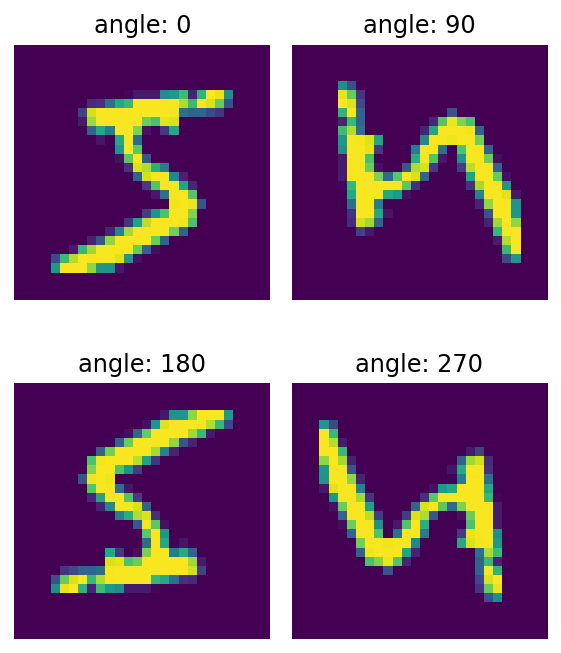

In [17]:
degrees = [0, 90, 180, 270]

fig, ax = plt.subplots(2, 2, figsize=(4, 5))
for axi, deg in zip(ax.flat, degrees):
    x_shift = processor(X_train[0], deg)
    
    axi.imshow(x_shift)
    axi.axis("off")
    axi.set_title(f"angle: {deg}")
plt.tight_layout()

In [18]:
key = jax.random.PRNGKey(314)

batch_size = 2000
n_epochs = 50
alpha = 0.001
tx = optax.adam(learning_rate=alpha)
model = gendist.models.MLPDataV1(n_classes)

proc_class = gendist.processing.Factory(processor)
degrees = np.r_[np.linspace(0, 90, 50), np.linspace(180, 270, 50)]
n_configs = len(degrees)

In [27]:
config = {"angle": 0.0}
train_config = gendist.training.TrainingBase(model, proc_class,
                              gendist.training.make_cross_entropy_loss_func, tx)
train_output = train_config.fit(key, X_train, y_train_ohe,
                                                    config, n_epochs, batch_size)

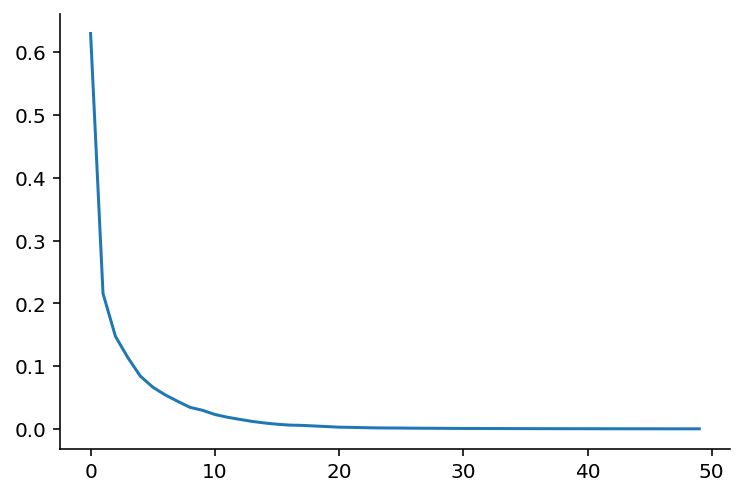

In [29]:
plt.plot(train_output["losses"])

In [ ]:
loss = gendist.training.make_cross_entropy_loss_func
train_config = gendist.training.TrainingBase(model, proc_class, loss, tx)

configs_params = []
configs_accuracy = []
configs_losses = []

for deg in tqdm(degrees):
    config = {"angle": float(deg)}
    train_output = train_config.fit(key, X_train, y_train_ohe, config, n_epochs, batch_size)
    
    configs_params.append(train_output["params"])
    configs_accuracy.append(train_output["train_accuracy"])
    configs_losses.append(train_output["losses"])

In [33]:
filename = "data-params.pkl"
filename = os.path.join(path_output, filename)

output_elements = {
    "configs": degrees,
    "params": configs_params,
    "metric": configs_accuracy
}

with open(filename, "wb") as f:
    pickle.dump(output_elements, f)

In [ ]:
filename = "data-params.pkl"
filename = os.path.join(path_output, filename)

with open(filename, "rb") as f:
    output_elements = pickle.load(f)

    radii = output_elements["configs"]
    configs_params = output_elements["params"]
    configs_accuracy = output_elements["metric"]

In [34]:
configs_params_flat, fn_recontruct_params = gendist.processing.flat_and_concat_params(configs_params)

In [35]:
configs_params_flat.shape

(100, 1033510)

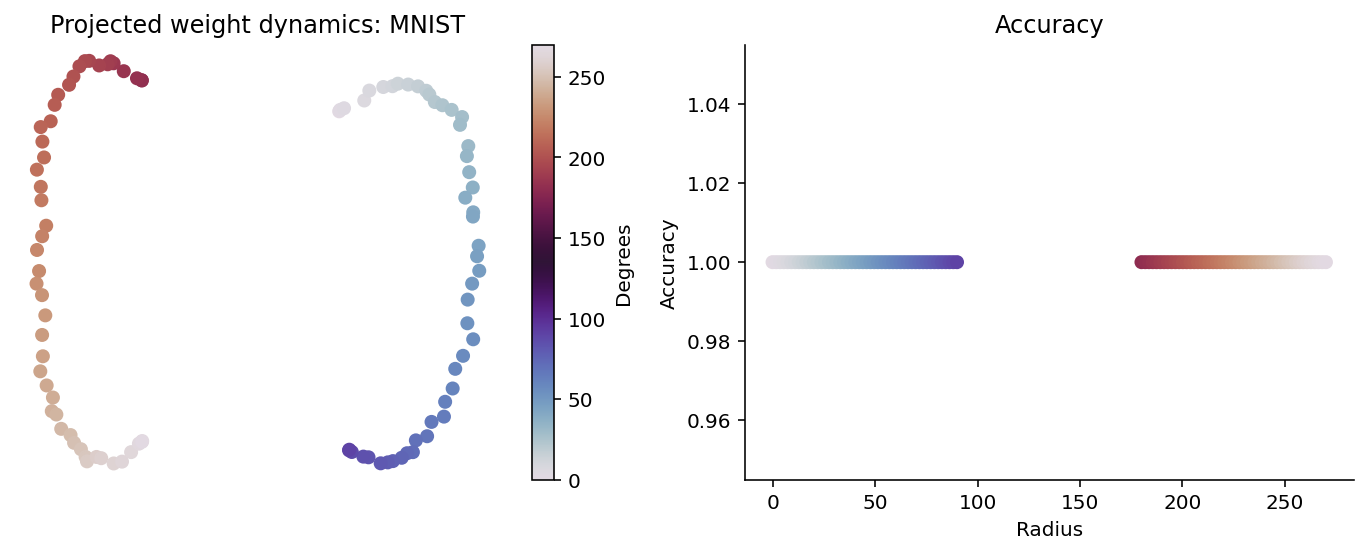

In [36]:
pca = PCA(n_components=2)
params_proj = pca.fit_transform(configs_params_flat)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].set_title("Projected weight dynamics: MNIST")
im =  ax[0].scatter(*params_proj.T, c=degrees, cmap="twilight")
fig.colorbar(im, ax=ax[0], label="Degrees")

ax[0].tick_params(axis="both", labelleft=False, labelbottom=False)
ax[0].axis("equal")
ax[0].axis("off")


ax[1].set_title("Accuracy")
ax[1].scatter(degrees, configs_accuracy, c=degrees, cmap="twilight")
ax[1].set_xlabel("Radius")
ax[1].set_ylabel("Accuracy");

## Training weights

In [37]:
n_components = 60
pca = PCA(n_components=n_components)
params_proj = pca.fit_transform(configs_params_flat)

In [38]:
angle_dict = [{"angle": float(deg)} for deg in degrees]

In [39]:
n_train_subset = 6_000
subset_ix = pd.Series(y_train).sample(n_train_subset, random_state=314)
subset_ix = subset_ix.index.values
subset_ix

array([46242, 52277, 30471, ..., 18692,  3212,   220])

In [40]:
imap = np.ones((n_configs, 1, 28, 28))
X_train_shift = X_train[subset_ix] * imap
X_train_shift = X_train_shift.reshape(-1, 28, 28)
X_train_shift.shape

tcmalloc: large alloc 3763200000 bytes == 0x55e1af21c000 @  0x7f4937b21680 0x7f4937b42824 0x7f491626d1ed 0x7f491626d267 0x7f49162afc1b 0x7f49162afed8 0x7f4916361177 0x7f4916362dec 0x7f49164a8652 0x55e0322ede88 0x55e03246f5d8 0x7f4916369ff7 0x55e0323db520 0x55e032416568 0x55e0323cfb32 0x55e03247fddc 0x55e0323d0b5b 0x55e0324b58fe 0x55e0323ae581 0x55e0323483be 0x55e0323c0d34 0x55e03241a3ff 0x55e0323c0d34 0x55e03241a3ff 0x55e0323c0d34 0x55e0323ca0a3 0x55e0323481a4 0x55e0323d08c3 0x55e0323483be 0x55e0323d08c3 0x55e0323481a4


(600000, 28, 28)

In [49]:
degrees_shift = (degrees[:, None] * np.ones((1, 6000))).reshape(-1)

degrees_shift = [{"angle": float(angle)} for angle in degrees_shift]

X_train_shift = proc_class(X_train_shift, degrees_shift)

tcmalloc: large alloc 1881604096 bytes == 0x55e2d8056000 @  0x7f4937b21680 0x7f4937b42824 0x7f491626d1ed 0x7f491626d267 0x7f49162afc1b 0x7f491634cb5e 0x7f491634d37a 0x7f491634d5ae 0x55e03238fe64 0x55e0323897e4 0x7f491629ca74 0x55e03238fe88 0x55e032389e4f 0x55e032415937 0x55e0323cfb32 0x55e0323d0697 0x55e032347f00 0x55e0323d08c3 0x55e0323481a4 0x55e0323cfb32 0x55e0323d0697 0x55e0323c060a 0x55e0323c09d5 0x55e032389e4f 0x55e032415937 0x55e0323cfb32 0x55e03247fddc 0x55e0323d0b5b 0x55e0324b58fe 0x55e0323ae581 0x55e0323483be


In [63]:
X_train_shift = X_train_shift.reshape((n_train_subset, n_configs, -1), order="F")
X_train_shift.shape

(6000, 100, 784)

In [58]:
y_train_shift = params_proj[None, ...]
y_train_shift.shape

(1, 100, 60)

In [72]:
alpha = 0.01
n_epochs = 100
batch_size = 2000
tx = optax.adam(learning_rate=alpha)
lossfn = gendist.training.make_multi_output_loss_func
weights_model = gendist.models.MLPWeightsV1(n_components)
train_weights = gendist.training.TrainingMeta(weights_model, lossfn, tx)

In [74]:
meta_output = train_weights.fit(key, X_train_shift, y_train_shift, n_epochs, batch_size)

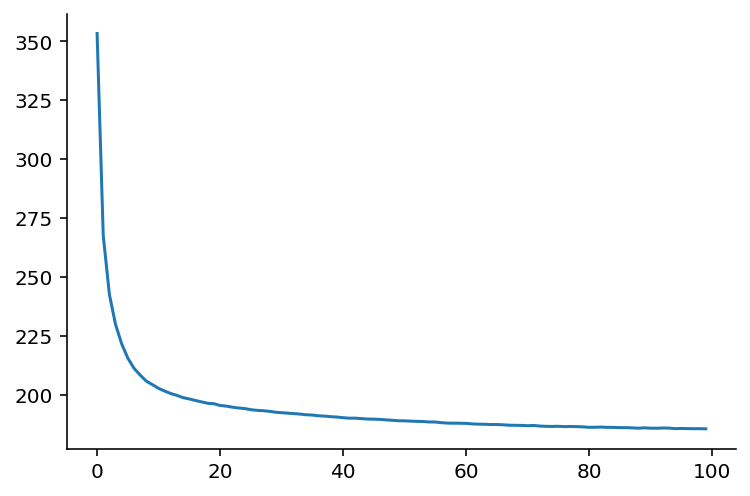

In [84]:
plt.plot(meta_output["losses"])

In [85]:
jnp.power(weights_model.apply(meta_output["params"], X_train_shift) - y_train_shift, 2).mean()

DeviceArray(3.062267, dtype=float32)

## Old stufff

In [86]:
filename = "meta-params.pkl"
filename = os.path.join(path_output, filename)

with open(filename, "wb") as f:
    pickle.dump(meta_output, f)

# Proxy zero-shot learning

In [87]:
angle_test = np.linspace(0, 360, 100)

In [88]:
logger.remove()
filename = f"trench-test-c{n_components}.log"
filename = os.path.join(path_logs, filename)
logger.add(filename, rotation="5mb")

1

In [89]:
def predict_shifted_dataset(ix_seed, X_batch, processor, config, wmodel, wparams, dmodel, proj, fn_reconstruct):
    """
    Parameters
    ----------
    ix_seed: array
    X_batch: array
    ...
    wmodel: model for the latent space
    wparams: trained weights for the latent space
    dmodel: model for the observed space
    dparams: trained model for the observed weights
    """
    x_seed = X_batch[ix]
    x_shift = processor.process_single(x_seed, **config).ravel()
    predicted_weights = wmodel.apply(wparams, x_shift)
    predicted_weights = proj.inverse_transform(predicted_weights)
    predicted_weights = fn_reconstruct(predicted_weights)
    
    X_batch_shift = processor(X_batch, config)
    y_batch_hat = dmodel.apply(predicted_weights, X_batch_shift)
    
    return y_batch_hat

In [92]:
ix = 4
accuracy_configs_learned = []
predicted_weights_array = []

for angle in tqdm(angle_test):
    config = {"angle": float(angle)}
    
    y_test_hat = predict_shifted_dataset(ix, X_test, proc_class, config,
                                         weights_model, meta_output["params"], model, pca, fn_recontruct_params)
    y_test_hat = y_test_hat.argmax(axis=1)
    
    accuracy_learned = (y_test_hat == y_test).mean()
    accuracy_configs_learned.append(accuracy_learned.item())
    
    # predicted_weights_array.append(predicted_weights)
    
    logger.info(f"{angle=:0.4f} | {accuracy_learned=:0.4f}")

  0%|          | 0/100 [00:00<?, ?it/s]

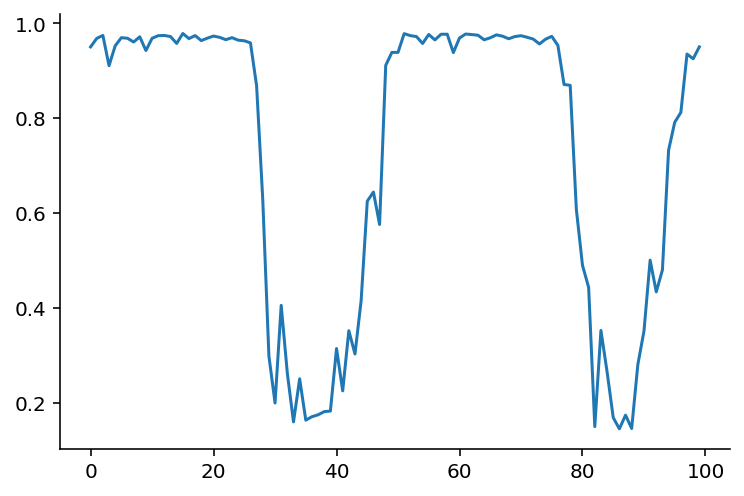

In [93]:
plt.plot(accuracy_configs_learned)

In [94]:
logger.remove()
filename = f"trench-test-c{n_components}-multiple.log"
filename = os.path.join(path_logs, filename)
logger.add(filename, rotation="5mb")

2

In [ ]:
accuracy_configs_learned = []
predicted_weights_array = []

ixs = [0, 1, 2, 3, 4]
for angle in tqdm(angle_test):
    config = {"angle": float(angle)}
    
    acc_dict = {}
    params_dict = {}
    for ix in ixs:
        y_test_hat = predict_shifted_dataset(ix, X_test, proc_class, config,
                                             weights_model, meta_output["params"], model, pca, fn_recontruct_params)
        y_test_hat = y_test_hat.argmax(axis=1)
        accuracy_learned = (y_test_hat == y_test).mean().item()
        acc_dict[ix] = accuracy_learned
        
    accuracy_configs_learned.append(acc_dict)
    
    logger_row = "|".join([format(v, "0.2%") for v in acc_dict.values()])
    logger_row = f"{angle=:0.4f} | " + logger_row 
    
    logger.info(logger_row)

  0%|          | 0/100 [00:00<?, ?it/s]

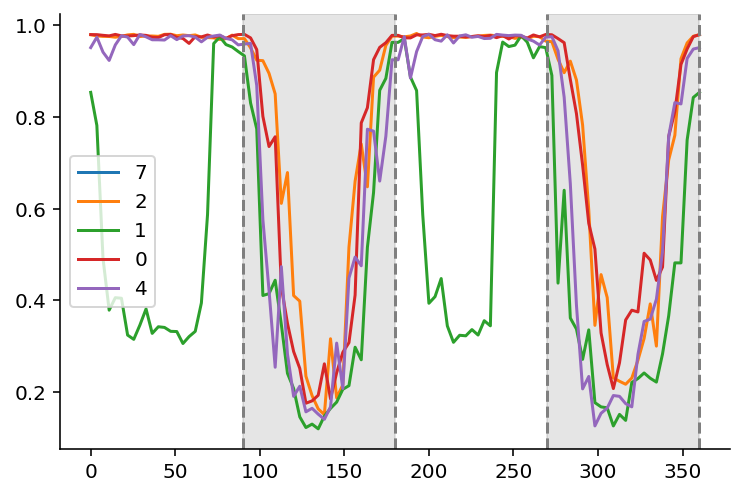

In [242]:
acc_df = pd.DataFrame(accuracy_configs_learned, index=angle_test, columns=y_test[ixs])
acc_df.plot()

plt.axvline(x=90, c="tab:gray", linestyle="--")
plt.axvline(x=180, c="tab:gray", linestyle="--")
plt.axvspan(90, 180, alpha=0.2, color="tab:gray")

plt.axvline(x=270, c="tab:gray", linestyle="--")
plt.axvline(x=360, c="tab:gray", linestyle="--")
plt.axvspan(270, 360, alpha=0.2, color="tab:gray")


We evaluate the predicted weights on the training dataset

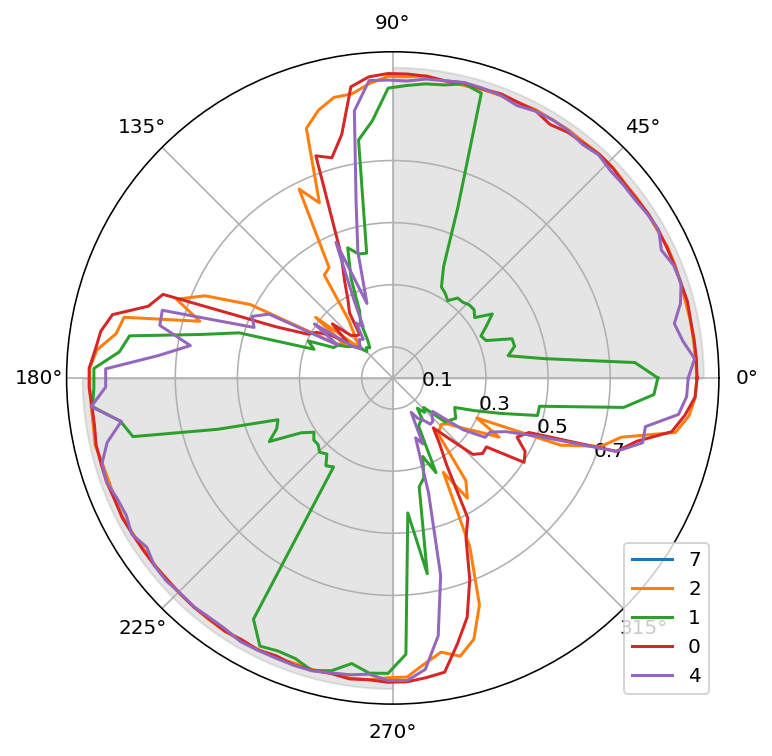

In [247]:
fig, ax = plt.subplots(subplot_kw={"projection": "polar"}, figsize=(6, 6))
acc_df.set_index(acc_df.index.values * np.pi / 180).plot(ax=ax)
ax.set_rticks([0.1, 0.3, 0.5, 0.7])  # Less radial ticks
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.fill_between(np.linspace(0, np.pi/2, 100), 0, 1.0, alpha=0.2, color="tab:gray")
ax.fill_between(np.linspace(np.pi, 3 * np.pi/2, 100), 0, 1.0, alpha=0.2, color="tab:gray")
plt.legend(loc="lower right")

ax.grid(True)